# A comparison of 10K corhort thrombolysis rates across hospitals using different model types

Here we train models either by training independent models for each hospital, or by one-coding hospitals and training a single model.

The use of thrombolysis in an independent 10K corhort may then be predicted at each hospital by either selecting the individual hospital model for that hospital, or by changing the one-hot encoding to mimic all those 10K patients attending each hospital.

We test three model types (each with both hospital-level models or a single model with one-hot hospital encoding):

* Random forest
* XG Boost
* Logistic regression

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

## Function to standardise data

In [2]:
def standardise_data(X_train, X_test):
    """
    Converts all data to a similar scale.
    Standardisation subtracts mean and divides by standard deviation
    for each feature.
    Standardised data will have a mena of 0 and standard deviation of 1.
    The training data mean and standard deviation is used to standardise both
    training and test set data.
    """
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Load data

In [3]:
data_loc = '../../data/sam_1/10k_training_test/'

train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

## Random forest model trained for each hospital

In [4]:
hospitals = set(train['StrokeTeam'])
counter = 0
models = dict()
observed = []
predicted = []

for hospital in hospitals:
    counter += 1
    print(f'\r{counter}', end='') 
    
    # Get hospital data
    mask = train['StrokeTeam'] == hospital
    X_train_hosp = train[mask].drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    y_train = train[mask]['S2Thrombolysis']
    
    mask = test['StrokeTeam'] == hospital
    X_test_hosp = test[mask].drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    y_test = test[mask]['S2Thrombolysis']
    
    # Define model
    model = RandomForestClassifier(
        n_estimators=100, n_jobs=-1, class_weight='balanced', random_state=42)

    # Fit model
    model.fit(X_train_hosp, y_train)
    
    # Save to dictionary
    models[hospital] = model
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_hosp)[:,1]
    y_pred = y_probs > 0.5
    
    # Store results
    observed.extend(y_test.values)
    predicted.extend(y_pred * 1)
    
 # Show accuracy
accuracy = np.mean(np.array(observed) == np.array(predicted))
print (f'\nAccuracy: {accuracy:0.2f}')

132
Accuracy: 0.83


### Pass 10k cohort through all hospital models and get thrombolysis rate

In [5]:
hospitals = set(train['StrokeTeam'])
thrombolysis_rate = []

# Get X and y
X_train = train.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
X_test = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)

for hospital in hospitals:
    
    # Get hospital model
    model = models[hospital]
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
rf_multi = thrombolysis_rate

### Plot thrombolysis rate of 10K cohort at each hospital

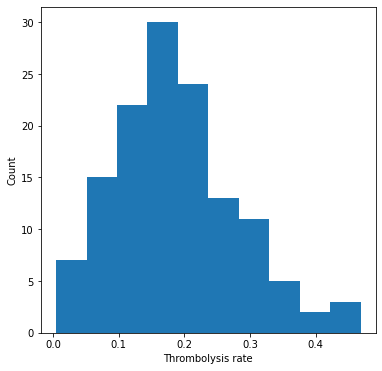

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate)
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [7]:
mean = np.mean(thrombolysis_rate)
stdev = np.std(thrombolysis_rate)

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')

Mean: 0.186
StDev: 0.094


## Single Random Forest Model

Random forest model trained using one-hot encoded hospitals

### Train model

In [8]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)    

# Define model
model = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, class_weight='balanced', random_state=42)

# Fit model
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy}')

Accuracy: 0.8422


### Pass 10k cohort through all hospital models and get thrombolysis rate

In [9]:
hospitals = set(train['StrokeTeam'])
thrombolysis_rate = []

for hospital in hospitals:
    
    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
rf_single = thrombolysis_rate

### Plot thrombolysis rate of 10K cohort at each hospital

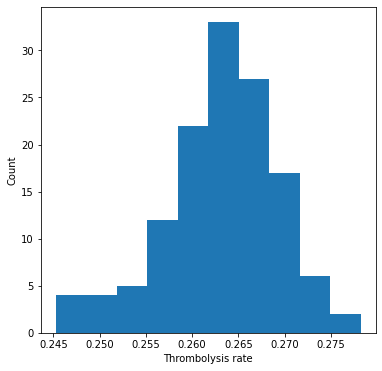

In [10]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate)
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [11]:
mean = np.mean(thrombolysis_rate)
stdev = np.std(thrombolysis_rate)

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')

Mean: 0.263
StDev: 0.006


### XG Boost model fitted to each hospital

In [12]:
hospitals = set(train['StrokeTeam'])
counter = 0
models = dict()
observed = []
predicted = []

for hospital in hospitals:
    counter += 1
    print(f'\r{counter}', end='') 
    
    # Get hospital data
    mask = train['StrokeTeam'] == hospital
    X_train_hosp = train[mask].drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    y_train = train[mask]['S2Thrombolysis']
    
    mask = test['StrokeTeam'] == hospital
    X_test_hosp = test[mask].drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    y_test = test[mask]['S2Thrombolysis']
    
    # Define model
    model = XGBClassifier(verbosity = 0)

    # Fit model
    model.fit(X_train_hosp, y_train)
    
    # Save to dictionary
    models[hospital] = model
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_hosp)[:,1]
    y_pred = y_probs > 0.5
    
    # Store results
    observed.extend(y_test.values)
    predicted.extend(y_pred * 1)
    
 # Show accuracy
accuracy = np.mean(np.array(observed) == np.array(predicted))
print (f'\nAccuracy: {accuracy:0.2f}')

132
Accuracy: 0.83


### Pass 10k cohort through all hospital models and get thrombolysis rate

In [13]:
hospitals = set(train['StrokeTeam'])
thrombolysis_rate = []

# Get X and y
X_train = train.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
X_test = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)

for hospital in hospitals:
    
    # Get hospital model
    model = models[hospital]
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
xgb_multi = thrombolysis_rate

### Plot thrombolysis rate of 10K cohort at each hospital

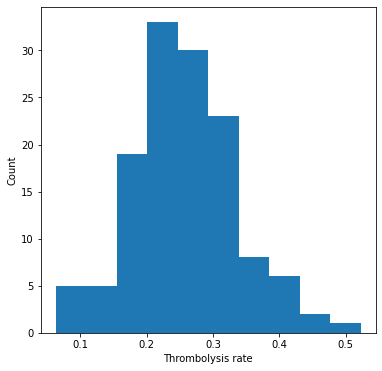

In [14]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate)
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [15]:
mean = np.mean(thrombolysis_rate)
stdev = np.std(thrombolysis_rate)

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')

Mean: 0.257
StDev: 0.080


## Single XG Boost Model

### Train model

In [16]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)    

# Define model
model = XGBClassifier(verbosity = 0)

# Fit model
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy}')

Accuracy: 0.8528


### Pass 10k cohort through all hospital models and get thrombolysis rate

In [17]:
hospitals = set(train['StrokeTeam'])
thrombolysis_rate = []

for hospital in hospitals:
    
    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
xgb_single = thrombolysis_rate

### Plot thrombolysis rate of 10K cohort at each hospital

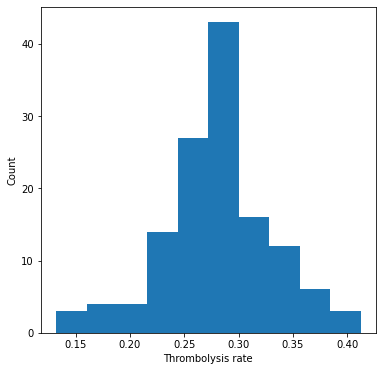

In [18]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate)
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [19]:
mean = np.mean(thrombolysis_rate)
stdev = np.std(thrombolysis_rate)

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')

Mean: 0.279
StDev: 0.050


## Logistic regression model fitted to each hospital

In [20]:
hospitals = set(train['StrokeTeam'])
counter = 0
models = dict()
observed = []
predicted = []

for hospital in hospitals:
    counter += 1
    print(f'\r{counter}', end='') 
    
    # Get hospital data
    mask = train['StrokeTeam'] == hospital
    X_train_hosp = train[mask].drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    y_train = train[mask]['S2Thrombolysis']
    
    mask = test['StrokeTeam'] == hospital
    X_test_hosp = test[mask].drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    y_test = test[mask]['S2Thrombolysis']
    
    # Define model
    model = XGBClassifier(verbosity = 0)

    # Fit model
    model.fit(X_train_hosp, y_train)
    
    # Standardise X data
    X_train_std, X_test_std = standardise_data(X_train_hosp, X_test_hosp)

    # Define model
    model = LogisticRegression(solver='lbfgs')

    # Fit model
    model.fit(X_train_std, y_train)
    
    # Save to dictionary
    models[hospital] = model
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_std)[:,1]
    y_pred = y_probs > 0.5
    
    # Store results
    observed.extend(y_test.values)
    predicted.extend(y_pred * 1)
    
 # Show accuracy
accuracy = np.mean(np.array(observed) == np.array(predicted))
print (f'\nAccuracy: {accuracy:0.2f}')

132
Accuracy: 0.81


### Pass 10k cohort through all hospital models and get thrombolysis rate

In [21]:
hospitals = set(train['StrokeTeam'])
thrombolysis_rate = []

# Get X and y
X_train = train.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
X_test = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)

# Standardise X data
X_train_std, X_test_std = standardise_data(X_train, X_test)

for hospital in hospitals:
    
    # Get hospital model
    model = models[hospital]
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_std)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
lr_multi = thrombolysis_rate

### Plot thrombolysis rate of 10K cohort at each hospital

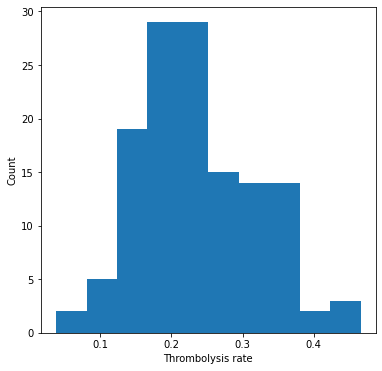

In [22]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate)
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [23]:
mean = np.mean(thrombolysis_rate)
stdev = np.std(thrombolysis_rate)

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')

Mean: 0.236
StDev: 0.081


## Single logistic regression model

### Train model

In [24]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)

# Standardise X data
X_train_std, X_test_std = standardise_data(X_train, X_test)

# Define model
model = LogisticRegression(solver='lbfgs')

# Fit model
model.fit(X_train_std, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test_std)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy}')

Accuracy: 0.8262


### Pass 10k cohort through all hospital models and get thrombolysis rate

In [25]:
hospitals = set(train['StrokeTeam'])
thrombolysis_rate = []

for hospital in hospitals:
    
    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Standardised
    X_train_std, X_test_std = standardise_data(X_train, X_test_adjusted)
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_std)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
lr_single = thrombolysis_rate

### Plot thrombolysis rate of 10K cohort at each hospital

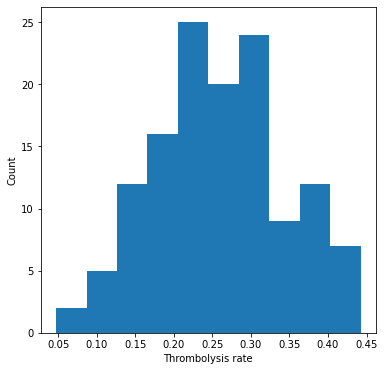

In [26]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate)
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [27]:
mean = np.mean(thrombolysis_rate)
stdev = np.std(thrombolysis_rate)

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')

Mean: 0.259
StDev: 0.085


## Show comparisions between models

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics  

slr = LinearRegression()

def compare(x, y, x_label, y_label):
    
    x = np.array(x).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    
    slr.fit(x, y)
    y_pred = slr.predict(x)
    r_square = metrics.r2_score(y, y_pred)
    
    print(f'R squared {r_square:0.3f}')
    
    plt.scatter (x, y, c = 'blue')
    plt.plot (x, slr.predict(x), color = 'red')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(0,0.5)
    plt.ylim(0,0.5)
    
    plt.show()  
    

Compare single vs multi models for each type

R squared 0.596


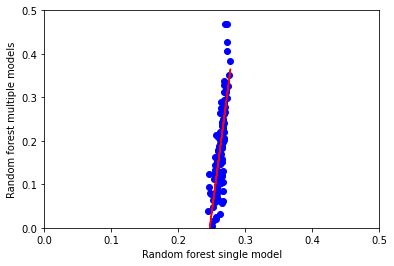

In [29]:
compare(rf_single, rf_multi, 'Random forest single model', 'Random forest multiple models')

R squared 0.823


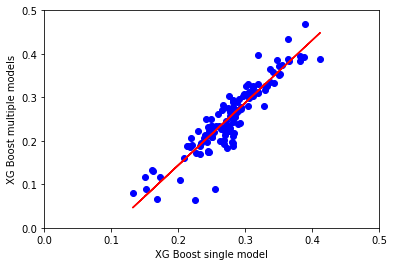

In [30]:
compare(xgb_single, xgb_multi, 'XG Boost single model', 'XG Boost multiple models')

R squared 0.465


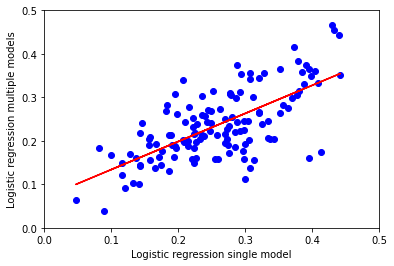

In [31]:
compare(lr_single, lr_multi, 'Logistic regression single model', 'Logistic regression multiple models')

Compare single fit models

R squared 0.726


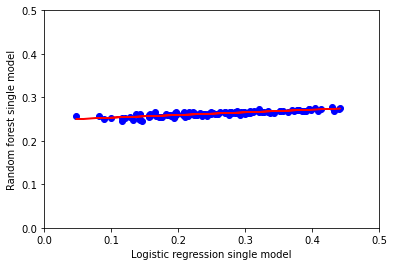

In [32]:
compare(lr_single, rf_single, 'Logistic regression single model', 'Random forest single model')

R squared 0.868


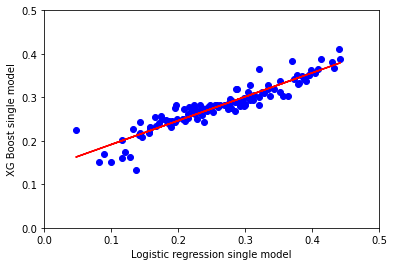

In [33]:
compare(lr_single, xgb_single, 'Logistic regression single model', 'XG Boost single model')

R squared 0.731


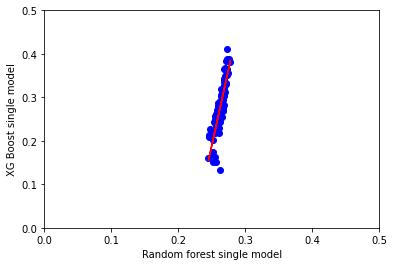

In [34]:
compare(rf_single, xgb_single, 'Random forest single model', 'XG Boost single model')

Compare multi-fit models

R squared 0.549


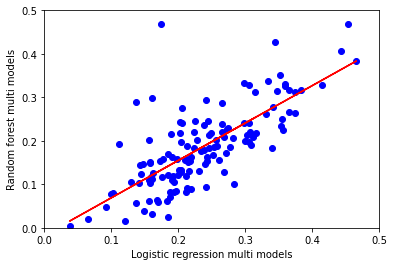

In [35]:
compare(lr_multi, rf_multi, 'Logistic regression multi models', 'Random forest multi models')

R squared 0.434


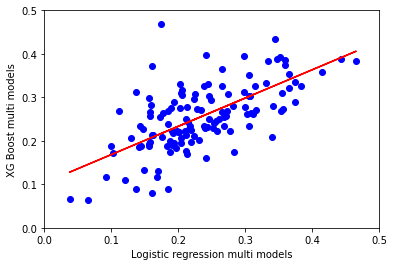

In [36]:
compare(lr_multi, xgb_multi, 'Logistic regression multi models', 'XG Boost multi models')

R squared 0.895


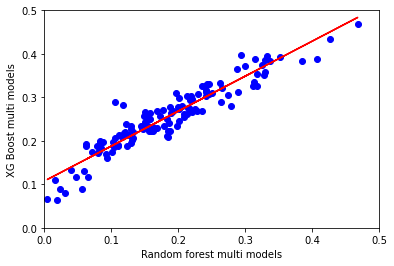

In [37]:
compare(rf_multi, xgb_multi, 'Random forest multi models', 'XG Boost multi models')

## Observations

A single fit random forest model loses the influence of hospital attended on thrombolysis rate.